# Задание 2. Создание сверточной сети для  MNIST

Создайте сверточную сеть на PyTorch и обучите ее на MNIST.
* Используйте не более трёх [сверточных 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) и не более двух [полносвязных 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) слоев, а также [pooling-слои 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) (слой pooling и аргумент `stride` у сверточных слоев помогут уменьшить число параметров линейного слоя).
* Не применяйте слои, которых не было в лекциях.
* Функцию активации выберите на свое усмотрение.
* Рекомендуется использовать код для обучения из задания №1 лекции №5. Для логирования используйте `SummaryWriter` из `torch.utils.tensorboard`.
* Отладку кода рекомендуем производить на небольшой части датасета (как обычно).
* Используйте GPU. Для этого необходимо в верхней панели выбрать `Среда выполнения > Сменить среду выполнения` и заменить `CPU` на `T4 GPU`.

Установка и импорт необходимых библиотек:

In [ ]:
import os
import sys

import torch
import torchmetrics
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from collections import defaultdict
from torch.nn.modules.pooling import MaxPool2d
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, utils
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from IPython.display import clear_output

import torch
import torchmetrics
import lightning as L
import torch.nn as nn
import matplotlib.pyplot as plt

from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassAUROC,
)
from lightning.pytorch.callbacks import ModelCheckpoint
from tbparse import SummaryReader

from kan import KANLayer
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from source import lmdKANLayer

import random


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001DE5F3F31F0>
Traceback (most recent call last):
  File "c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\torch\utils\data\dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch 0:  41%|████▏     | 81/196 [1:55:18<2:43:42,  0.01it/s, v_num=2, loss=2.300]


In [76]:
class ReLUKANLayer(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 output_size: int,
                 grid: int, 
                 overlap : int = 1,  
                 train_ab: bool = True,
                 basis_f_left_boarder : float = -1.,
                 basis_f_right_boarder : float = 1.,
                 init_mu : float = 0.,
                 init_sigma : float = 1.):
        '''
        KAN layer with relu-based activation functions basis.
        
        Args:
        -----
            input_size : int
                Size of input vector.
            output_size : 
                Size of output vector.
            grid : int
                Number of basis functions per each learning 1-variable function.
            overlap : float>0
                Measure of overlapping initialized basis functions. 0 makes basis f. as delta-functions; (0,1] - central basis f. overlapping with 2 others basis.f.. 
            train_ab : bool
                Whether trainable basis functions or not.
            basis_f_left_boarder : float
                Left boarder of initialized basis functions` grid. Corresponds to the leftmost basis f. center position.
            basis_f_right_boarder : float
                Right boarder of initialized basis functions` grid. Corresponds to the rightmost basis f. center position.
            init_mu : float
                Mean of initialisation distribution of coefficients.
            init_sigma : float
                Dispertion of initialisation distribution of coefficients.
        '''
        super().__init__()
        self.grid, self.overlap = grid, overlap
        self.input_size, self.output_size = input_size, output_size
        self.basis_f_left_boarder, self.basis_f_right_boarder = basis_f_left_boarder, basis_f_right_boarder
        
        basis_f_centers = np.linspace(basis_f_left_boarder, basis_f_right_boarder, self.grid) # centers of basis. functions
        basis_f_step = (basis_f_right_boarder - basis_f_left_boarder) / (self.grid - 1)
        phase_low = basis_f_centers - basis_f_step
        phase_height = basis_f_centers + basis_f_step
        
        self.phase_low = nn.Parameter(torch.Tensor(np.array([phase_low for i in range(input_size)])),
                                      requires_grad=train_ab)
        self.phase_height = nn.Parameter(torch.Tensor(np.array([phase_height for i in range(input_size)])),
                                         requires_grad=train_ab)
        
        #self.equal_size_conv = nn.Conv2d(1, output_size, (g+k, input_size))
        
        # torch.Size([input_size, output_size, grid])
        self.coff = torch.nn.Parameter(init_mu + init_sigma * (torch.randn(self.input_size, self.output_size, self.grid))).requires_grad_(True)
        
        
    def forward(self, x):
        # input x:              torch.Size([Batch, input_size, 1])
        # self.phase_low:       torch.Size([input_size, grid])
        # self.phase_height:    torch.Size([input_size, grid])
        
        # Norming coefficient norms each basis function to [0,1] range. Don`t provide gradients.
        norm_coeff = (self.phase_height.detach().clone() - self.phase_low.detach().clone())**4 / 16
        
        x = x.unsqueeze(dim=-1) # torch.Size([Batch, input_size, 1])
        #print(f'x:\t\t\t {x.shape}')
        x1 = torch.relu(x - self.phase_low) # torch.Size([Batch, input_size, grid])
        #print(f'x1:\t\t\t {x1.shape}')
        x2 = torch.relu(self.phase_height - x) # torch.Size([Batch, input_size, grid])
        #print(f'x2:\t\t\t {x2.shape}')
        x = x1 * x2 # torch.Size([Batch, input_size, grid])
        #print(f'x1 * x2:\t\t {x2.shape}')
        x = x**2 * norm_coeff # torch.Size([Batch, input_size, grid])
        #print(f'x**2:\t\t\t {x.shape}')
        x = x.unsqueeze(dim=2) # torch.Size([Batch, input_size, 1, grid])
        x = (self.coff * x).sum(dim=(1,3), keepdim=False) # torch.Size([Batch, output_size])
        #print(f'reshape x:\t\t {x.shape}')
        return x

In [ ]:
def load_model_from_ckpt(model, log_path):
    '''
    Provides loading model from best checkpoint.
    '''
    ckpt_path = f"{log_path}/checkpoints/model.ckpt"
    checkpoint = torch.load(ckpt_path, weights_only=False)

    print(f"Checkpoint has been loaded from {ckpt_path}")
    print(f"Best model has been saved on the {checkpoint['epoch']} epoch")

    state_dict = {}
    for key in checkpoint["state_dict"].keys():
        key_new = key[6:]
        state_dict[key_new] = checkpoint["state_dict"][key]

    model.load_state_dict(state_dict)

In [243]:
def show_sensitivity(W, title = ''):
    '''
    Shows sensitivity maps for Linear Regression and Lambda KAN models.
    
    W : np.array
        size = [28*28, 10]
    '''
    # Display templates
    plt.rcParams["figure.figsize"] = (25, 10)

    #W = np.loadtxt("lc_mnist_weights.txt")  # load weigths, shape (785, 10)
    print(f"Shape with bias: {W.shape}")

    ## Remove bias
    #W = W[:-1, :]
    #print(f"Shape without bias: {W.shape}")

    # Normalize
    w_min, w_max = np.min(W), np.max(W)
    templates = 255 * (W - w_min) / (w_max - w_min)

    # Display templates
    labels_names = [str(i) for i in range(10)]
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        img = templates[:, i].reshape(28, 28).astype(int)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(labels_names[i], size=25)
        
    plt.suptitle(title, size=50)
    plt.tight_layout()
    plt.subplots_adjust(top=1.44)
    plt.show()
    plt.close()

Shape with bias: (784, 10)


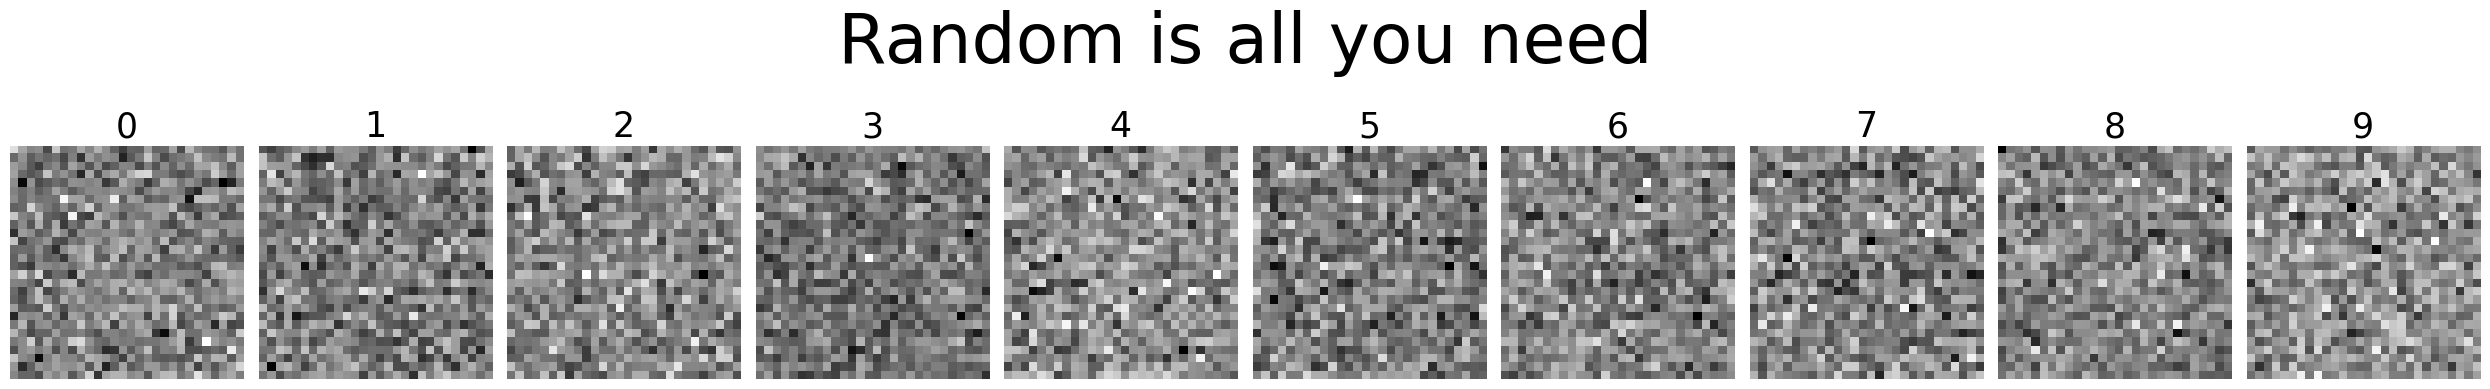

In [244]:
W = torch.randn(28*28, 10).numpy()

show_sensitivity(W, title='Random is all you need')

In [77]:
input_var = torch.randn(2,28*28)

kan_layer = ReLUKANLayer(
    output_size=3,
    input_size=28*28,
    grid=7,
    overlap=2
    )

print(f'phase_low: {kan_layer.phase_low.shape}')
print(f'phase_height: {kan_layer.phase_height.shape}')

print(f'output_var: {kan_layer(input_var).shape}')

phase_low: torch.Size([784, 7])
phase_height: torch.Size([784, 7])
output_var: torch.Size([2, 3])


#### ReLU KAN:

In [134]:
class MnistKAN(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()
        self.act = nn.Tanh
        self.layers = nn.Sequential(
            nn.Flatten(),
            ReLUKANLayer(input_size=28 * 28, output_size=10, 
                         grid=10, overlap=1.,
                         basis_f_left_boarder=0, basis_f_right_boarder=1,
                         init_mu=1),
            #self.act(),
            #nn.Linear(32, 16),
            #self.act(),
            nn.Linear(10, 10),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

##### Spline KAN:

In [127]:
class SplineKANLayer(KANLayer):
    def forward(self, x):
        y, preacts, postacts, postspline = super().forward(x)
        return y

In [132]:
class MnistSplineKAN(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()
        self.act = nn.Tanh
        self.layers = nn.Sequential(
            nn.Flatten(),
            SplineKANLayer(in_dim=28 * 28, out_dim=10, 
                           num=5, k=3),
            #self.act(),
            #nn.Linear(64, 32),
            #self.act(),
            nn.Linear(10, 10),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [129]:
model = MnistSplineKAN()

input_var = torch.randn(2,28,28)

print(f'output_var: {model(input_var).shape}')

output_var: torch.Size([2, 10])


#### Spline parallel KAN:

In [ ]:
class MnistPrllSplineKAN(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()
        self.act = nn.Tanh
        self.l_layers = nn.ModuleList()
        for i in range(10):
            layers = nn.Sequential(
                nn.Flatten(),
                SplineKANLayer(in_dim=28 * 28, out_dim=16, 
                               num=5, k=3),
                self.act(),
                nn.Linear(16, 8),
                self.act(),
                nn.Linear(8, 1),
            )
            self.l_layers.append(layers)

    def forward(self, x):
        l_logits = []
        for i in range(10):
            l_logits.append(self.l_layers[i](x))
            
        y = torch.cat(l_logits, dim=-1)
        return y

In [183]:
model = MnistPrllSplineKAN()

input_var = torch.randn(2,28,28)

print(f'output_var: {model(input_var).shape}')

output_var: torch.Size([2, 10])


#### lambda KAN:

In [212]:
class lmdSplineKANLayer(lmdKANLayer):
    def forward(self, x):
        y, preacts, postacts, postspline, beforelmd = super().forward(x)
        return y

In [ ]:
class Mnist_lmdSplineKAN(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()
        self.act = nn.Tanh
        self.l_layers = nn.ModuleList()
        for i in range(10):
            layers = nn.Sequential(
                nn.Flatten(),
                lmdSplineKANLayer(in_dim=28 * 28, out_dim=64, 
                                  num=5, k=3),
                self.act(),
                nn.Linear(64, 32),
                self.act(),
                nn.Linear(32, 1),
            )
            self.l_layers.append(layers)

    def forward(self, x):
        l_logits = []
        for i in range(10):
            l_logits.append(self.l_layers[i](x))
            
        y = torch.cat(l_logits, dim=-1)
        return y

#### MLP:

In [92]:
class MnistMLP(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()
        self.act = nn.ReLU
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            self.act(),
            nn.Linear(256, 64),
            self.act(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

#### CNN:

In [82]:
class MnistCNN(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()
        self.conv_stack = nn.Sequential(
            # [1, 28, 28]
            nn.Conv2d(1, 5, 3, padding=1),  # in channel=1, out=5
            nn.ReLU(),
            # [5, 28, 28]
            nn.MaxPool2d(2),
            # [5, 14, 14]
            nn.Conv2d(5, 10, 3, padding=1),  # in channel=5, out=10
            nn.ReLU(),
            # [10, 14, 14]
            nn.MaxPool2d(2),
            # [10, 7, 7]
        )
        self.cl = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10 * 7 * 7, 100),  # in = channel*heght*width
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.cl(x)
        return x

#### Linear Regression:

In [84]:
class MnistLR(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 10)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

Загрузите [MNIST 🛠️[doc]](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST):

In [214]:
batch_size = 256

transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

mnist = datasets.MNIST(root="./", train=True, download=True, transform=transform)

(train_set, val_set,) = torch.utils.data.random_split(
    mnist, [50000, 10000], generator=torch.Generator().manual_seed(42)
)
test_set = datasets.MNIST(root="./", train=False, download=True, transform=transform)

val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)

### Код LightningModule

Этим кодом мы заменим наш train loop из второго задания. Ваша задача — дописать недостающий код.

In [215]:
class LModel(L.LightningModule):
    def __init__(self, model, lr=0.001):
        super().__init__()
        self.save_hyperparameters(logger=False)

        # for optimizer and shaduler
        self.lr = lr

        # model
        self.model = model
        self.criterion = nn.CrossEntropyLoss()

        # metrics
        self.metrics = MetricCollection([
            MulticlassAccuracy(num_classes=10,),
            #MulticlassF1Score(num_classes=10,),
            #MulticlassAUROC(num_classes=10,)
        ])
        self.train_metrics = self.metrics.clone(postfix='/train')
        self.val_metrics = self.metrics.clone(postfix='/val')

    def configure_optimizers(self):
        # set optimizer
        optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=self.lr,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  # or 'step'
                "monitor": "loss" # only for self.log
            },
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.train_metrics.update(out, y)
        self.log("loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.val_metrics.update(out, y)

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

        val_metrics = self.val_metrics.compute()
        self.log_dict(val_metrics)
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.metrics.update(out, y)

    def on_test_epoch_end(self):
        self.log_dict(self.metrics.compute())
        self.metrics.reset()

Запустим обучение модели: TensorBoard можно обновлять и следить за обучением.

In [245]:
checkpoint_callback = ModelCheckpoint(
    # dirpath='best_ckp/'
    save_last=True,
    every_n_epochs=1,
    save_top_k=1,
    save_weights_only=True,
    monitor="MulticlassAccuracy/val",
    filename="model",
    mode="max",
)

L.seed_everything(1755)

model = MnistLR() #Mnist_lmdSplineKAN() #MnistPrllSplineKAN() #MnistSplineKAN() #MnistSplineKAN() #MnistKAN() #MnistMLP() #MnistCNN() #MnistLR()
pl_model = LModel(model)
trainer = L.Trainer(
    max_epochs=20,
    callbacks=[checkpoint_callback],
    num_sanity_val_steps=0,
    log_every_n_steps=10,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./logs/lmdSplineKAN/"),
)

trainer.fit(
    model=pl_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

Seed set to 1755
c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MnistLR          | 7.9 K  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | metrics       | MetricCollection | 0      | train
3 | train_metrics | MetricCollection | 0      | train
4 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
11        Mo

Epoch 19: 100%|██████████| 196/196 [00:08<00:00, 23.94it/s, v_num=2, loss=0.279]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 196/196 [00:08<00:00, 23.77it/s, v_num=2, loss=0.279]


In [292]:
# Load the best checkpoint automatically (lightning tracks this for you)
trainer.test(
    model=pl_model, dataloaders=test_loader, verbose=True, ckpt_path="best"
)

Restoring states from the checkpoint path at ./logs/lmdSplineKAN/lightning_logs\version_2\checkpoints\model.ckpt
Loaded model weights from the checkpoint at ./logs/lmdSplineKAN/lightning_logs\version_2\checkpoints\model.ckpt


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 44.64it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.9249136447906494     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.9249136447906494}]

In [ ]:
log_path='logs/LR/lightning_logs/version_0/'
ckpt_path = f"{log_path}/checkpoints/last.ckpt"

pl_model = LModel.load_from_checkpoint(ckpt_path)

# Load the best checkpoint automatically (lightning tracks this for you)
LR_acc = trainer.test(
    model=pl_model, dataloaders=test_loader, verbose=True)[0]['MulticlassAccuracy']
pl_model

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 40.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │     0.926193118095398     │
└───────────────────────────┴───────────────────────────┘

Shape with bias: (784, 10)


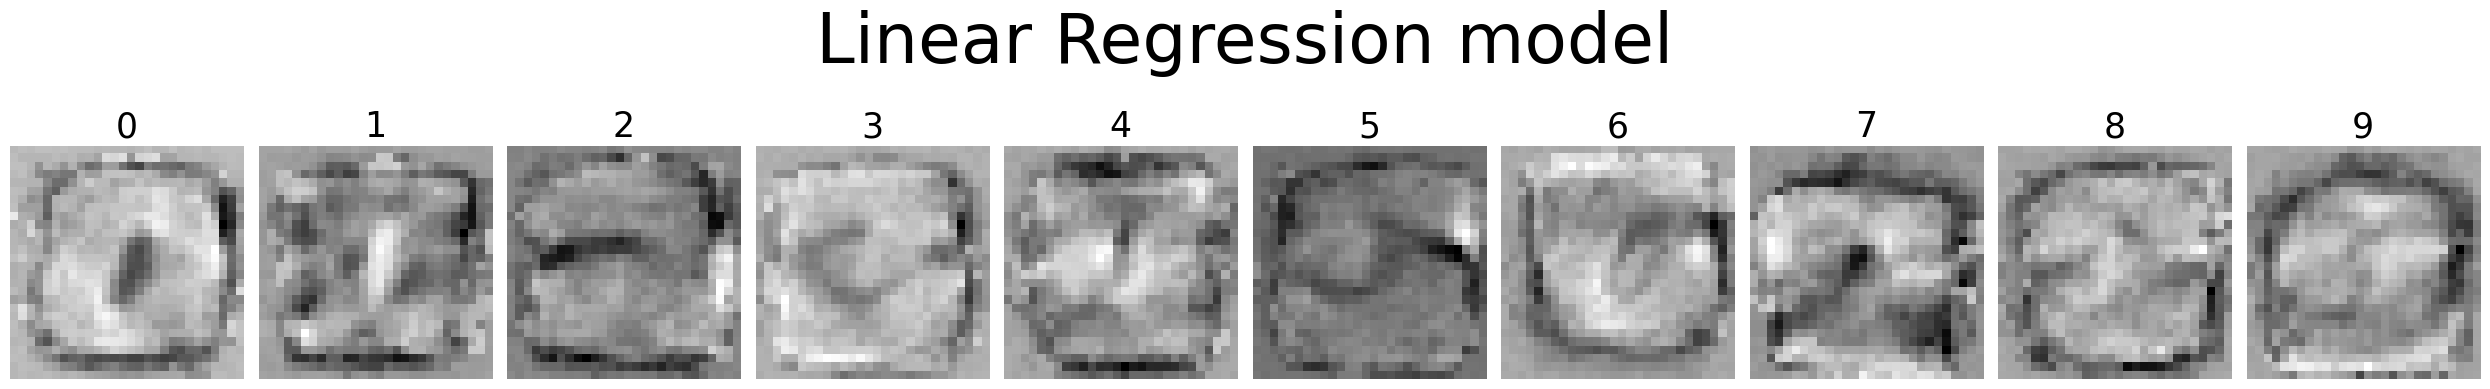

In [331]:
LR_layer = pl_model.model.layers[1].state_dict()
W = LR_layer['weight'].permute(1,0).detach().clone().numpy()

show_sensitivity(W, title='Linear Regression model')

In [ ]:
log_path='logs/lmdSplineKAN/lightning_logs/version_0/'
ckpt_path = f"{log_path}/checkpoints/last.ckpt"

pl_model = LModel.load_from_checkpoint(ckpt_path)
# Load the best checkpoint automatically (lightning tracks this for you)
lmdKAN_acc = trainer.test(
    model=pl_model, dataloaders=test_loader, verbose=True)[0]['MulticlassAccuracy']
pl_model

FileNotFoundError: [Errno 2] No such file or directory: 'c:/Users/Gavriil/VS_projects/lambda_KAN/mnist_example/logs/lmdSplineKAN/lightning_logs/version_1//checkpoints/last.ckpt'

In [ ]:
lmd_W = []
for i in range(10):
    lmd_W.append(pl_model.model.l_layers[9][1].lmd.detach().clone().numpy())

lmd_W = np.array(lmd_W).transpose(1,0)
show_sensitivity(lmd_W, title='lambda KAN model')

AttributeError: 'MnistLR' object has no attribute 'l_layers'

Полученные логи можно конвертировать в pandas при помощи [tbparse 🐾[git]](https://github.com/j3soon/tbparse) и отобразить, используя matplotlib.

Чтобы получить таблицу, где названия метрик соответствуют названиям столбцов, используем параметр `pivot=True`.

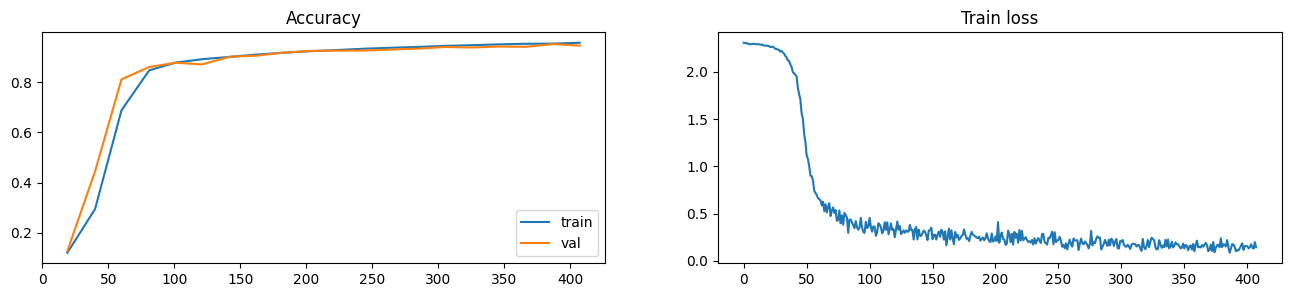

In [11]:
log_dir = trainer.logger.experiment.get_logdir()  # lightning_logs/version_x

reader = SummaryReader(log_dir, pivot=True)
df = reader.scalars


plt.figure(figsize=(16, 3))

def drop_nan(df, tag):
    return df[~df[tag].isna()].loc[:, tag]


plt.subplot(1, 2, 1).set_title("Accuracy")

plt.plot(drop_nan(df, "MulticlassAccuracy/train"), label="train")
plt.plot(drop_nan(df, "MulticlassAccuracy/val"), label="val")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2).set_title("Train loss")
plt.plot(drop_nan(df, "loss"))
plt.show()

In [17]:
# Load the best checkpoint automatically (lightning tracks this for you)
trainer.test(
    model=pl_model, dataloaders=test_loader, verbose=True, ckpt_path="best"
)

Restoring states from the checkpoint path at ./logs/ex3/lightning_logs\version_0\checkpoints\model.ckpt
Loaded model weights from the checkpoint at ./logs/ex3/lightning_logs\version_0\checkpoints\model.ckpt
c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 39.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.9570469856262207     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.9570469856262207}]